# Implementing Univariate Recurrent Neural Networks (RNN)

### 1. Introduction and data gathering

- The aim is to implement a model to predict stock prices (rather returns) because prices are closer to be interpreted as sequences than returns. This makes them potentially more predictive using RNNsn than returns.

In [65]:
import numpy as np
import pandas as pd
import yfinance as yf  
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
from keras.callbacks import EarlyStopping
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

- Gathering data and defining outputs

In [58]:
ts = TimeSeries(key=api_key, output_format='pandas')
df, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

# Rename columns
df.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
}, inplace=True)

# Delete the 'Volume' column
del df['Volume']

# Create a new 'Output' column (shifted 'Close' column)
df["Output"] = df["Close"].shift(-1)

# Reset index and preview the data
df.reset_index(inplace=True)

In [56]:
# df = yf.download("AAPL", start="2010-01-01", end="2022-04-11")
#del df['5. volume']
# df["Output"] = df.Close.shift(-1)
# df.reset_index(inplace=True)

In [57]:
print("Length of data frame:", len(df))
df.head()

Length of data frame: 6371


,date,Open,High,Low,Close,Output
0,2025-02-28,236.950,242.09,230.20,241.84,237.30
1,2025-02-27,239.410,242.46,237.06,237.30,240.36
2,2025-02-26,244.330,244.98,239.13,240.36,247.04
3,2025-02-25,248.000,250.00,244.91,247.04,247.10
4,2025-02-24,244.925,248.86,244.42,247.10,245.55


### 2. Validation, train, and test sample definition

- We define a window of observations that we're going to take as a sequence input into the network. 
- We choose a window of 20, which means that the last 20 prices (observations) will be incorporated into the sequence of inouts for the network. 

In [59]:
# First, we deal with the definition of the training, test, and validations sets sizes
val_split = 0.2
train_split = 0.98
train_size = int(len(df) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df) - train_size)

window_size = 20  # How many daily prices do I want to incorporate in the input sequence for the network?

ts = test_size
split_time = len(df) - ts
test_time = df.iloc[split_time + window_size :, 0:1].values

# Second, we actually define the input matrix for train (X_train) and test (X_test), as well as the output vector (y_train and y_test). See how we select 'Adj close' column for the Xdf matrix.
# Note that these will need further work afterwards, in order to incorporate the info from the 'sequence' of observations
Xdf, ydf = df.iloc[:, 4:5], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

# Third, we proceed with scaling inputs to the model. Note how this is specially important now (compare to past tasks) because we are no longer dealing with returns, but with prices!
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)


# Lastly, because we want a time series with up to 20 (window_size) past observations, we need to append these observations into our matrix/vectors!
training_time = df.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Size of X vector in training:", X_train.shape)
print("Size of Y vector in training:", y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])


X_test, y_test = np.array(X_test), np.array(y_test)
print("Size of X vector in test:", X_test.shape)
print("Size of Y vector in test:", y_test.shape)
print("Number of features in the model: ", n_features)

Size of X vector in training: (6223, 20, 1)
Size of Y vector in training: (6223, 1)
Size of X vector in test: (108, 20, 1)
Size of Y vector in test: (128, 1)
Number of features in the model:  1


### 3. Defining RNN Model

In [60]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(
            50, return_sequences=True, input_shape=(X_train.shape[1], n_features)
        ),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Dense(1),
    ]
)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,271 (71.37 KB)

 Trainable params: 18,271 (71.37 KB)

 Non-trainable params: 0 (0.00 B)

### 4. Model Training

In [62]:
from keras.callbacks import EarlyStopping

hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=[es],
)

Epoch 1/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.7432 - val_loss: 0.2063
Epoch 2/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5890 - val_loss: 0.1173
Epoch 3/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5192 - val_loss: 0.0786
Epoch 4/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4616 - val_loss: 0.0179
Epoch 5/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4081 - val_loss: 0.0274
Epoch 6/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.3625 - val_loss: 0.0542
Epoch 7/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3200 - val_loss: 0.0261
Epoch 8/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2887 - val_loss: 0.0428
Epoch 9/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2658 - val_loss: 0.0218
Epoch 10/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2373 - val_loss: 0.0252
Epoch 11/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2235 - val_loss: 0.0359
Epoch 12/500
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

- Visualize predictions

In [63]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


In [66]:
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred RNN": prediction, "values": values}
)
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%Y-%m-%d")
df_predictions.head()

,Date,Pred RNN,values
0,2000-04-04,102.014053,133.309998
1,2000-04-03,103.276367,135.809998
2,2000-03-31,102.824516,125.750000
3,2000-03-30,102.683472,135.940002
4,2000-03-29,105.860764,139.130005


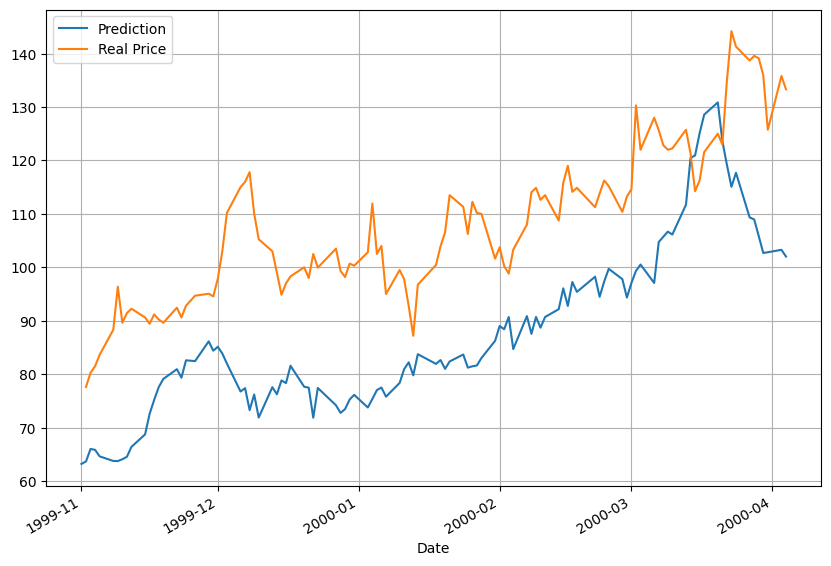

In [67]:
plt_1 = plt.figure(figsize=(10, 7))
ax = plt.gca()
df_predictions.plot(x="Date", y="Pred RNN", label="Prediction", ax=ax)
df_predictions.plot(x="Date", y="values", label="Real Price", ax=ax)
plt.grid()
plt.show()